In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
#from statsmodels.tsa import vector_ar
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy.stats import normaltest
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import probplot
from scipy.stats import jarque_bera

plt.style.use('ggplot')

In [2]:
df_historical = pd.read_csv("aws/google_trends/sample_data/historical.csv", parse_dates = ["date"], index_col= ["date"])[["bolsa de trabajo"]]
df_employment = pd.read_csv("aws/google_trends/sample_data/employment.csv", index_col = 0, parse_dates = ["time"])
df_employment = df_employment[df_employment["time"] >= "2016-01-01"]
df_employment['year'] = df_employment.time.dt.year
df_employment['month'] = df_employment.time.dt.month

In [3]:
df_employment.head()

,time,unemployment_rate,unemployment_rate_seas,subemployment_rate,year,month
0,2020-11-01,0.045458,0.043712,0.038706,2020,11
1,2020-10-01,0.046516,0.046977,0.045710,2020,10
2,2020-09-01,0.047539,0.050885,0.045150,2020,9
3,2020-08-01,0.049370,0.052405,0.051586,2020,8
4,2020-07-01,0.050586,0.053872,0.063444,2020,7


In [4]:
df_historical.head()

,bolsa de trabajo
date,
2015-12-20,43.0
2015-12-27,55.0
2016-01-03,100.0
2016-01-10,89.0
2016-01-17,90.0


In [5]:
df_monthly_historical = df_historical.resample("M").mean()
df_monthly_historical['year'] = df_monthly_historical.index.year
df_monthly_historical['month'] = df_monthly_historical.index.month

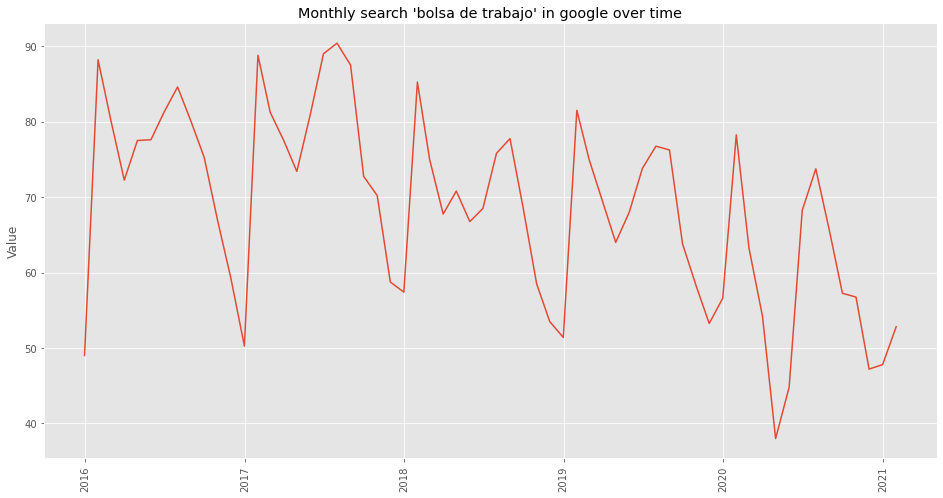

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df_monthly_historical["bolsa de trabajo"])
plt.xticks(rotation=90)
plt.title("Monthly search 'bolsa de trabajo' in google over time")
plt.ylabel("Value")
plt.show()

# Getting ready to test normality on residuals.
### Sample comes from a normal distribution
Using a D’Agostino and Pearson’s test using **skew** and **kurtosis** to produce **omnibus** test.<br>
This is not strictly necessary for the data on VAR models.

In [7]:
#null hypothesis: sample comes from a normal distribution
normaltest(df_monthly_historical["bolsa de trabajo"])

NormaltestResult(statistic=3.1273702929200358, pvalue=0.20936311410665592)

In [8]:
#platykurtic, however near 0 means normal
print("kurtosis: ", kurtosis(df_monthly_historical["bolsa de trabajo"]))
print("skew: ", skew(df_monthly_historical["bolsa de trabajo"]))

kurtosis:  -0.713684667569257
skew:  -0.3067167736640311


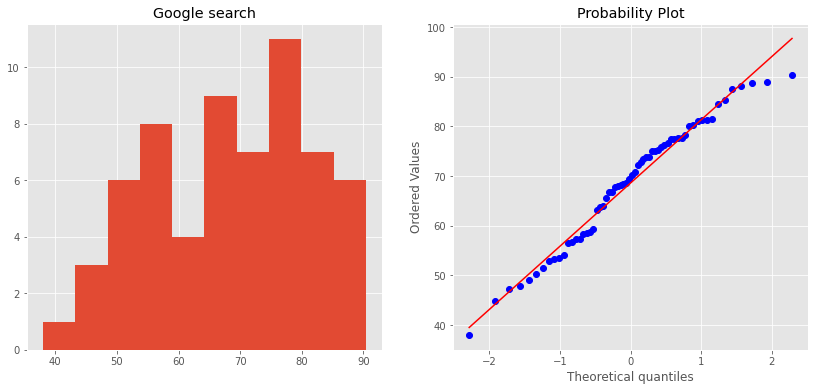

In [9]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df_monthly_historical["bolsa de trabajo"].hist(bins=10)
plt.title('Google search')
plt.subplot(1,2,2)
probplot(df_monthly_historical["bolsa de trabajo"], plot=plt);

In [10]:
#if a variable is non-stationary it posses a unit root test
if adfuller(df_monthly_historical["bolsa de trabajo"])[1] > 0.05:
    print("Non-stationary data")
else:
    print("Stationary data")

Non-stationary data


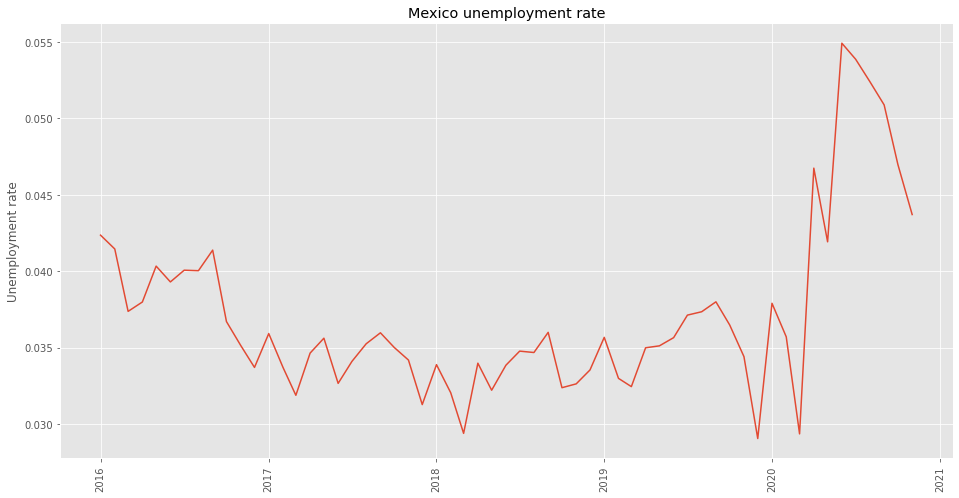

In [11]:
plt.figure(figsize=(16,8))
plt.plot(df_employment["time"], df_employment["unemployment_rate_seas"])
plt.xticks(rotation=90)
plt.title("Mexico unemployment rate")
plt.ylabel("Unemployment rate")
plt.show()

In [12]:
#null hypothesis: sample comes from a normal distribution
normaltest(df_employment["unemployment_rate_seas"])

NormaltestResult(statistic=22.75274364359597, pvalue=1.1463163681728665e-05)

In [13]:
#leptokurtic, however near 0 means normal
print("kurtosis: ", kurtosis(df_employment["unemployment_rate_seas"]))
print("skew: ", skew(df_employment["unemployment_rate_seas"]))

kurtosis:  1.988121822819056
skew:  1.4964869974023074


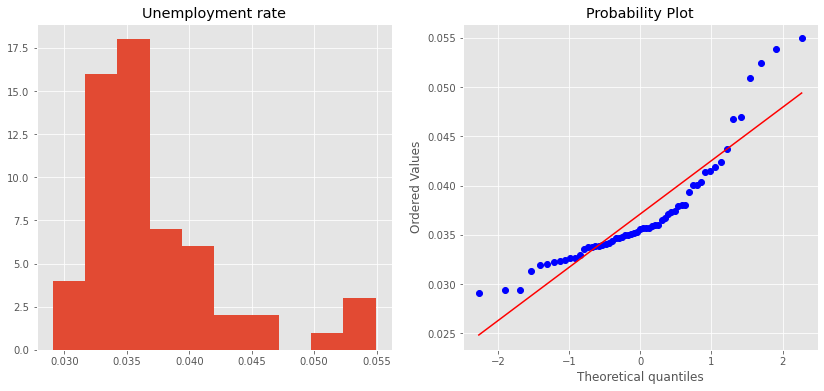

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df_employment["unemployment_rate_seas"].hist(bins=10)
plt.title('Unemployment rate')
plt.subplot(1,2,2)
probplot(df_employment["unemployment_rate_seas"], plot=plt);

In [15]:
if adfuller(df_employment["unemployment_rate_seas"])[1] > 0.05:
    print("Non-stationary data")
else:
    print("Stationary data")

Non-stationary data


### Grouped by data
There is a clear decline in the google searches over this years. However it seems that the mean movements in the monthly data mimic the ones in the unemployment rate. However still doubtfull about this, since search of employment might be before you be part of the unemployment statistic.

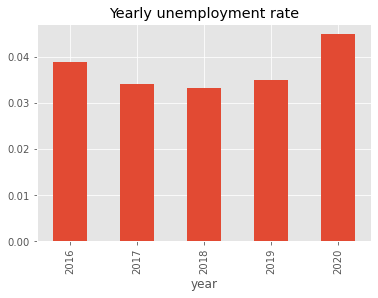

In [16]:
df_employment.groupby('year')['unemployment_rate_seas'].mean().plot.bar()
plt.title("Yearly unemployment rate")
plt.show()

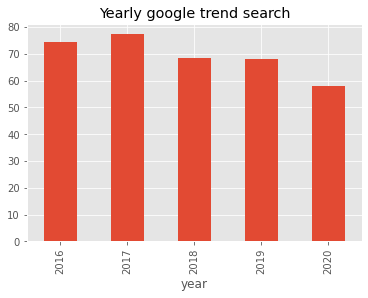

In [17]:
df_monthly_historical[(df_monthly_historical.year>2015) & (df_monthly_historical.year<2021)].groupby('year')['bolsa de trabajo'].mean().plot.bar()
plt.title("Yearly google trend search")
plt.show()

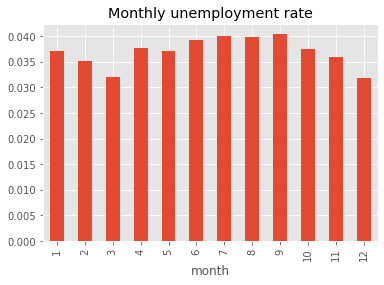

In [18]:
df_employment.groupby('month')['unemployment_rate_seas'].mean().plot.bar()
plt.title("Monthly unemployment rate")
plt.show()

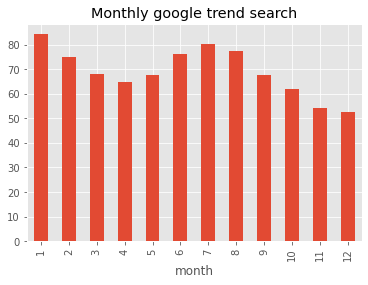

In [19]:
df_monthly_historical[(df_monthly_historical.year>2015) & (df_monthly_historical.year<2021)].groupby('month')['bolsa de trabajo'].mean().plot.bar()
plt.title("Monthly google trend search")
plt.show()

In [20]:
joined_df = pd.merge(df_monthly_historical, df_employment, on = ["year", "month"], how = "outer")[["bolsa de trabajo", "unemployment_rate_seas"]].dropna()

In [21]:
joined_df.corr()

,bolsa de trabajo,unemployment_rate_seas
bolsa de trabajo,1.000000,-0.085083
unemployment_rate_seas,-0.085083,1.000000


In [22]:
joined_df.pct_change().dropna().corr()

,bolsa de trabajo,unemployment_rate_seas
bolsa de trabajo,1.000000,0.260017
unemployment_rate_seas,0.260017,1.000000


In [23]:
joined_df.diff().dropna().corr()

,bolsa de trabajo,unemployment_rate_seas
bolsa de trabajo,1.000000,0.305433
unemployment_rate_seas,0.305433,1.000000


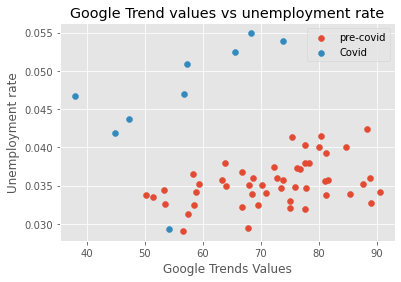

In [24]:
pre_covid = joined_df.iloc[:-9].dropna()
pos_covid = joined_df.iloc[-9:].dropna()

plt.scatter(pre_covid["bolsa de trabajo"], pre_covid["unemployment_rate_seas"], label="pre-covid")
plt.scatter(pos_covid["bolsa de trabajo"], pos_covid["unemployment_rate_seas"], label ="Covid")
plt.legend()
plt.title("Google Trend values vs unemployment rate")
plt.ylabel("Unemployment rate")
plt.xlabel("Google Trends Values")
#plt.scarrer()
#joined_df.plot.scatter(x = "bolsa de trabajo", y = "unemployment_rate_seas")
plt.show()

In [25]:
pre_covid_exog = sm.add_constant(pre_covid.to_numpy()[:, :1])

# Fit and summarize OLS model
mod = sm.OLS(pre_covid.to_numpy()[:, 1:], pre_covid_exog)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     9.575
Date:                Sat, 23 Jan 2021   Prob (F-statistic):            0.00329
Time:                        12:39:58   Log-Likelihood:                 225.43
No. Observations:                  50   AIC:                            -446.9
Df Residuals:                      48   BIC:                            -443.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0272      0.003     10.264      0.0

In [26]:
pos_covid_exog = sm.add_constant(pos_covid.to_numpy()[:, :1])

# Fit and summarize OLS model
mod = sm.OLS(pos_covid.to_numpy()[:, 1:], pos_covid_exog)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     2.864
Date:                Sat, 23 Jan 2021   Prob (F-statistic):              0.134
Time:                        12:39:58   Log-Likelihood:                 32.852
No. Observations:                   9   AIC:                            -61.70
Df Residuals:                       7   BIC:                            -61.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0262      0.012      2.118      0.0

/home/mauriciomani/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


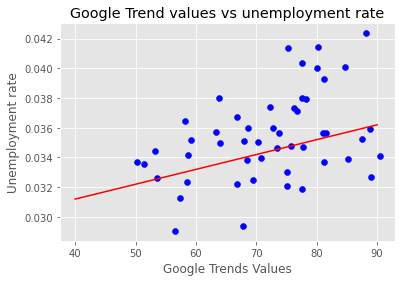

In [27]:
x1 = np.linspace(40,90,500)
y1=0.0001*x1+0.0272
plt.plot(x1,y1,'-r')
plt.scatter(pre_covid["bolsa de trabajo"], pre_covid["unemployment_rate_seas"], c="blue")
plt.title("Google Trend values vs unemployment rate")
plt.ylabel("Unemployment rate")
plt.xlabel("Google Trends Values")
#plt.scarrer()
#joined_df.plot.scatter(x = "bolsa de trabajo", y = "unemployment_rate_seas")
plt.show()

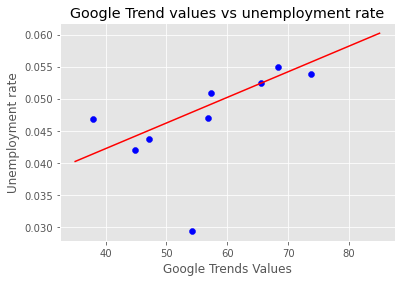

In [28]:
x1 = np.linspace(35,85,500)
y1=0.0004*x1+0.0262
plt.plot(x1,y1,'-r')
plt.scatter(pos_covid["bolsa de trabajo"], pos_covid["unemployment_rate_seas"], c="blue")
plt.title("Google Trend values vs unemployment rate")
plt.ylabel("Unemployment rate")
plt.xlabel("Google Trends Values")
#plt.scarrer()
#joined_df.plot.scatter(x = "bolsa de trabajo", y = "unemployment_rate_seas")
plt.show()

In [29]:
pre_covid["predicted"] = 0.0001 * pre_covid["bolsa de trabajo"] + 7.851e-05
pos_covid["predicted"] = 0.0004 * pos_covid["bolsa de trabajo"] + 0.0262

In [30]:
print(math.sqrt(sum((pre_covid["unemployment_rate_seas"] - pre_covid["predicted"])**2) / pre_covid.shape[0]))
print(math.sqrt(sum((pos_covid["unemployment_rate_seas"] - pos_covid["predicted"])**2) / pos_covid.shape[0]))

0.028221706682594667
0.006586378929017634


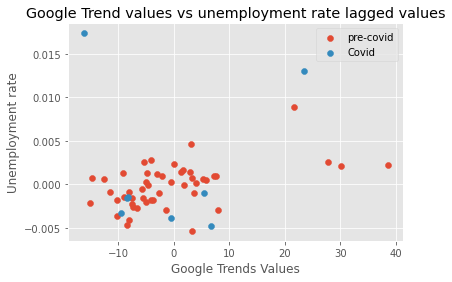

In [31]:
pre_covid_lagged = joined_df.iloc[:-9].diff().dropna()
pos_covid_lagged = joined_df.iloc[-9:].diff().dropna()

plt.scatter(pre_covid_lagged["bolsa de trabajo"], pre_covid_lagged["unemployment_rate_seas"], label="pre-covid")
plt.scatter(pos_covid_lagged["bolsa de trabajo"], pos_covid_lagged["unemployment_rate_seas"], label ="Covid")
plt.legend()
plt.title("Google Trend values vs unemployment rate lagged values")
plt.ylabel("Unemployment rate")
plt.xlabel("Google Trends Values")
#plt.scarrer()
#joined_df.plot.scatter(x = "bolsa de trabajo", y = "unemployment_rate_seas")
plt.show()

### Granger Causality Test

In [32]:
gc_test_pct_change = grangercausalitytests(pre_covid_lagged, maxlag = 12, verbose=False)
for key, p_value in gc_test_pct_change.items():
    if p_value[0]["ssr_chi2test"][1] < 0.05:
        print("Reject the null hypothesis: ", key)
        break

Reject the null hypothesis:  3


In [33]:
gc_test_pct_change = grangercausalitytests(joined_df.diff().dropna(), maxlag = 12, verbose=False)
for key, p_value in gc_test_pct_change.items():
    if p_value[0]["ssr_chi2test"][1] < 0.05:
        print("Reject the null hypothesis: ", key)
        break

Reject the null hypothesis:  7


### VAR
Capture de evolution of inter-dependecies between multiple time series. Using its own lagged series but other lagged time series.

In [34]:
mod = VAR(pre_covid_lagged)
res = mod.fit(maxlags=3, ic='aic')
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Jan, 2021
Time:                     12:39:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.15663
Nobs:                     46.0000    HQIC:                  -7.50469
Log likelihood:           60.8607    FPE:                0.000449034
AIC:                     -7.71318    Det(Omega_mle):     0.000338254
--------------------------------------------------------------------
Results for equation bolsa de trabajo
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -1.095547         1.461854           -0.749           0.454
L1.bolsa de trabajo              -0.060335         0.153909           -0.392           0.695
L

/home/mauriciomani/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


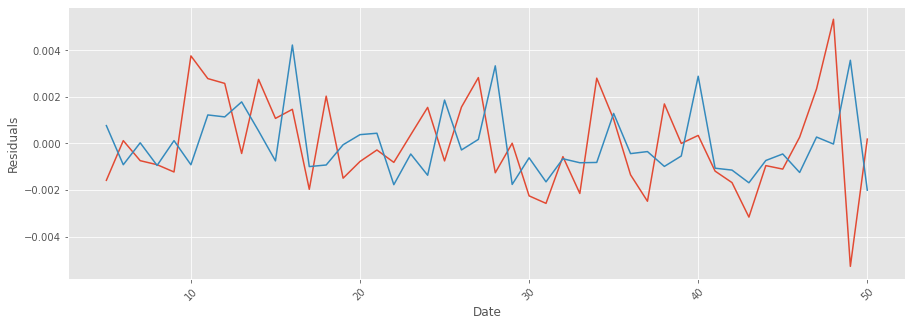

In [35]:
y_fitted = res.fittedvalues["unemployment_rate_seas"]
residuals = y_fitted - pre_covid_lagged["unemployment_rate_seas"][3:]
plt.figure(figsize = (15,5))
plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='VAR prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.grid(True)

In [36]:
y_fitted = res.fittedvalues["unemployment_rate_seas"]
residuals = y_fitted - pre_covid_lagged["unemployment_rate_seas"][3:]

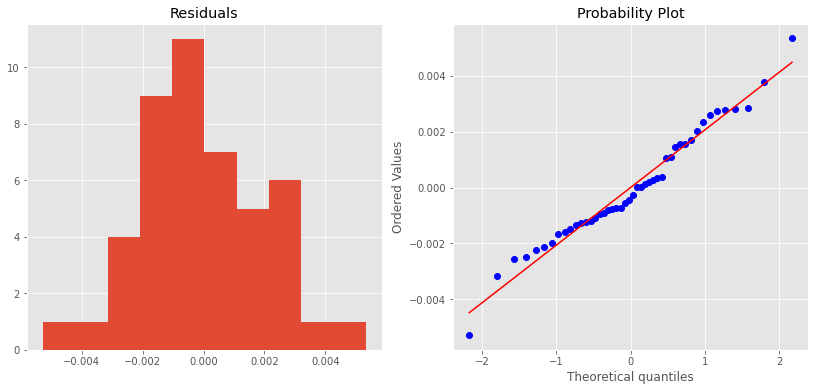

In [37]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
residuals.hist(bins=10)
plt.title('Residuals')
plt.subplot(1,2,2)
probplot(residuals, plot=plt);

In [45]:
print("Jarque Bera p-value: ", jarque_bera(residuals)[1])
print("kurtosis: ", kurtosis(df_monthly_historical["bolsa de trabajo"]))
print("skew: ", skew(df_monthly_historical["bolsa de trabajo"]))

Jarque Bera p-value:  0.7924461940412304
kurtosis:  -0.713684667569257
skew:  -0.3067167736640311


In [39]:
#There is no autocorrelation
durbin_watson(residuals)

1.9326072686786422

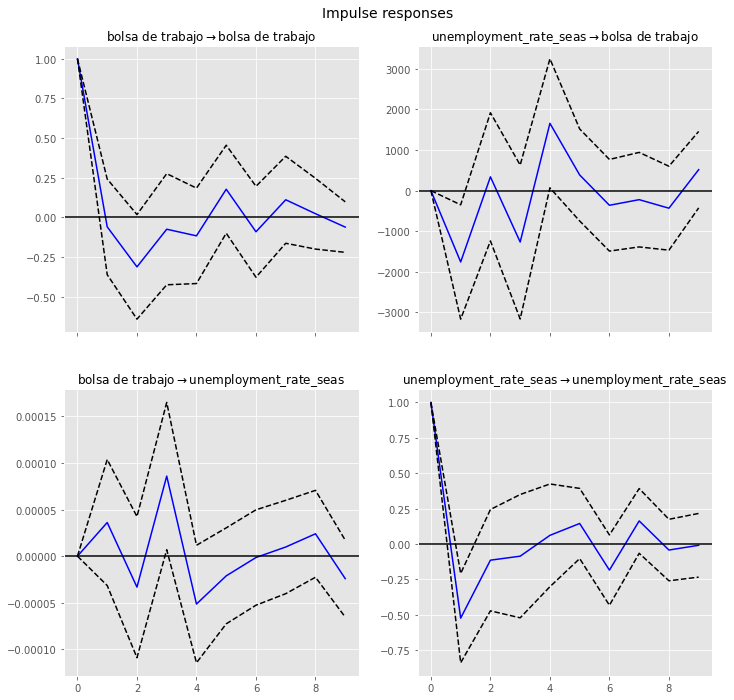

In [46]:
irf = res.irf(9)
irf.plot()
plt.show()

In [41]:
lag_order = res.k_ar
# Input data for forecasting
input_data = pre_covid_lagged.values[-lag_order:]
# forecasting
pred = res.forecast(y=input_data, steps=9)
pred = pd.DataFrame(pred, columns=joined_df.columns + '_pred')
#pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

   bolsa de trabajo_pred  unemployment_rate_seas_pred
0               3.685064                    -0.000489
1             -18.188902                    -0.000006
2               6.508878                    -0.001260
3               5.907160                     0.001492
4              -2.238112                    -0.002023
5               1.976580                     0.001323
6              -5.787094                    -0.000059
7               2.823892                    -0.000259
8              -2.570102                    -0.000096


In [42]:
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

output = invert_transformation(pre_covid[["bolsa de trabajo", "unemployment_rate_seas"]], pred)

In [43]:
output

,bolsa de trabajo_pred,unemployment_rate_seas_pred
0,66.935064,0.035223
1,48.746162,0.035217
2,55.255040,0.033957
3,61.162200,0.035450
4,58.924088,0.033427
5,60.900668,0.034750
6,55.113574,0.034691
7,57.937466,0.034432
8,55.367364,0.034337


#### RMSE, MAE for VAR using pos-covid

In [64]:
(sum(((pos_covid["unemployment_rate_seas"].to_numpy()*100) - (output["unemployment_rate_seas_pred"].to_numpy()*100))**2) / 9) / 100

0.02052371802857774

In [70]:
sum(np.absolute((pos_covid["unemployment_rate_seas"].to_numpy()) - (output["unemployment_rate_seas_pred"].to_numpy()))) / 9

0.013449447052218011